In [11]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

default_dir = "data/"

In [12]:
app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

# Display basic information about the dataset
print("Training set shape:", app_train.shape)
print("Testing set shape:", app_test.shape)

app_test.head()  


Training set shape: (307511, 122)
Testing set shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
def get_balance_data():
    pos_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int32, 'SK_DPD':np.int32,
        'SK_DPD_DEF':np.int32, 'CNT_INSTALMENT':np.float32,'CNT_INSTALMENT_FUTURE':np.float32
    }

    install_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'NUM_INSTALMENT_NUMBER':np.int32, 'NUM_INSTALMENT_VERSION':np.float32,
        'DAYS_INSTALMENT':np.float32, 'DAYS_ENTRY_PAYMENT':np.float32, 'AMT_INSTALMENT':np.float32, 'AMT_PAYMENT':np.float32
    }

    card_dtype = {
        'SK_ID_PREV':np.uint32, 'SK_ID_CURR':np.uint32, 'MONTHS_BALANCE':np.int16,
        'AMT_CREDIT_LIMIT_ACTUAL':np.int32, 'CNT_DRAWINGS_CURRENT':np.int32, 'SK_DPD':np.int32,'SK_DPD_DEF':np.int32,
        'AMT_BALANCE':np.float32, 'AMT_DRAWINGS_ATM_CURRENT':np.float32, 'AMT_DRAWINGS_CURRENT':np.float32,
        'AMT_DRAWINGS_OTHER_CURRENT':np.float32, 'AMT_DRAWINGS_POS_CURRENT':np.float32, 'AMT_INST_MIN_REGULARITY':np.float32,
        'AMT_PAYMENT_CURRENT':np.float32, 'AMT_PAYMENT_TOTAL_CURRENT':np.float32, 'AMT_RECEIVABLE_PRINCIPAL':np.float32,
        'AMT_RECIVABLE':np.float32, 'AMT_TOTAL_RECEIVABLE':np.float32, 'CNT_DRAWINGS_ATM_CURRENT':np.float32,
        'CNT_DRAWINGS_OTHER_CURRENT':np.float32, 'CNT_DRAWINGS_POS_CURRENT':np.float32, 'CNT_INSTALMENT_MATURE_CUM':np.float32
    }

    pos_bal = pd.read_csv(os.path.join(default_dir,'POS_CASH_balance.csv'), dtype=pos_dtype)
    install = pd.read_csv(os.path.join(default_dir,'installments_payments.csv'), dtype=install_dtype)
    card_bal = pd.read_csv(os.path.join(default_dir, 'credit_card_balance.csv'), dtype=card_dtype)

    return pos_bal, install, card_bal

pos_bal, install, card_bal = get_balance_data()

In [14]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [15]:
# Column types
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [16]:
# get object-type columns
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [17]:
le = LabelEncoder() # label encoder object
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count += 1

print(f"Number of label-encoded columns: {le_count}")

Number of label-encoded columns: 3


In [18]:
# one-hot encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [19]:
train_labels = app_train['TARGET']

# align test and train columns, hence "inner"
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# adding the target back in
app_train['TARGET'] = train_labels


The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


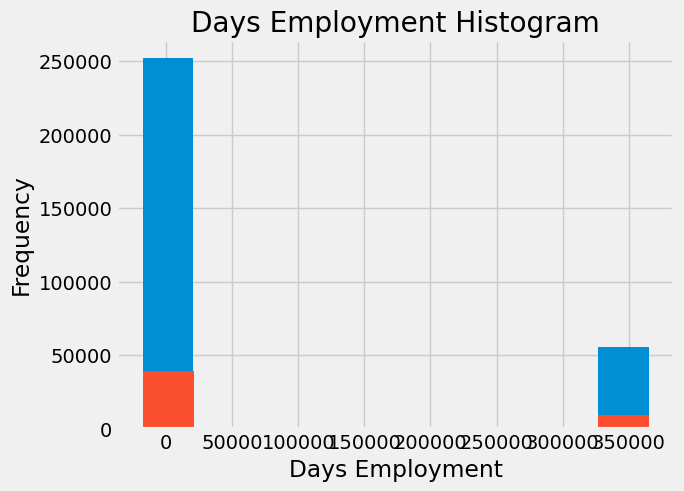

In [20]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

app_test['DAYS_EMPLOYED'][app_test['DAYS_EMPLOYED'] > 200000]

# understand the anomolies
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

There are 9274 anomalies in the test data out of 48744 entries



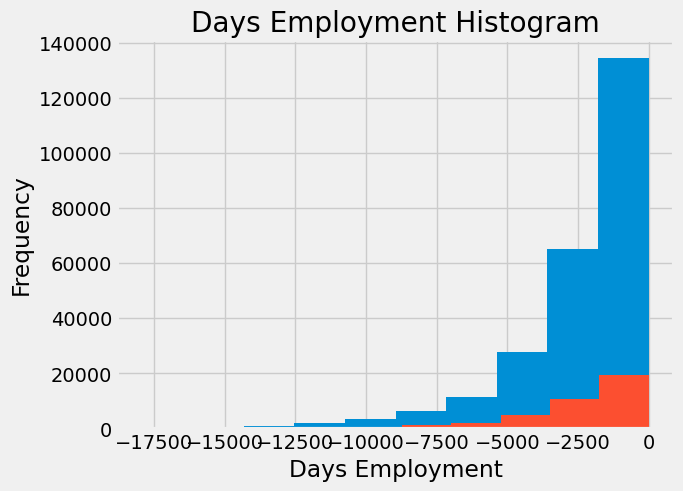

In [21]:
# Creating an anomolies flag
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
app_test['DAYS_EMPLOYED'].plot.hist()
plt.xlabel('Days Employment')

print('There are %d anomalies in the test data out of %d entries\n' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

In [22]:
# find the correlations
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [23]:
# Find the correlation of the birth dates and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

# as clients get older, they tend to repay their loans on time

np.float64(-0.07823930830982694)

Text(0, 0.5, 'Count')

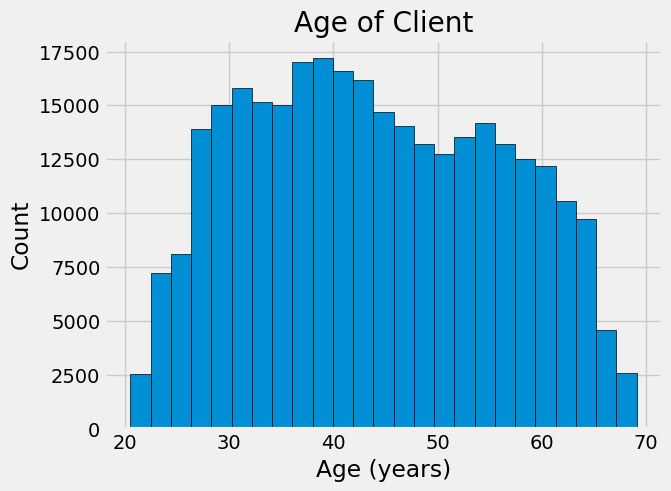

In [24]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

Text(0.5, 1.0, 'Distribution of Ages')

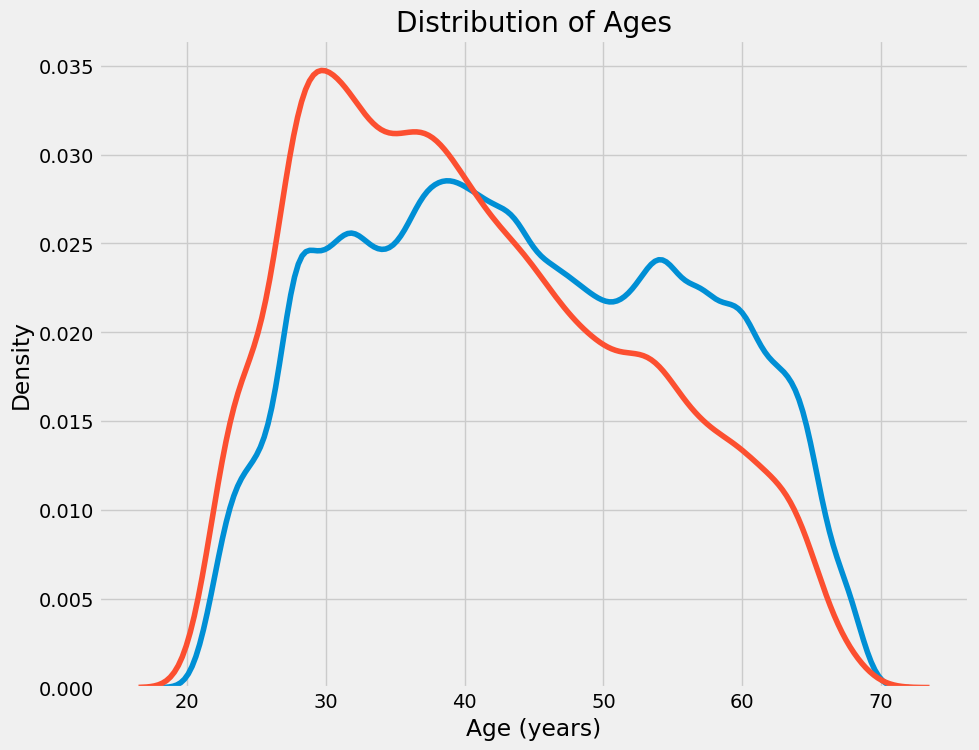

In [25]:
# Effect of age on target

import seaborn as sns

plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')

In [26]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

/tmp/ipykernel_2606/965416935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
/tmp/ipykernel_2606/965416935.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
/tmp/ipykernel_2606/965416935.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, 'Failure to Repay by Age Group')

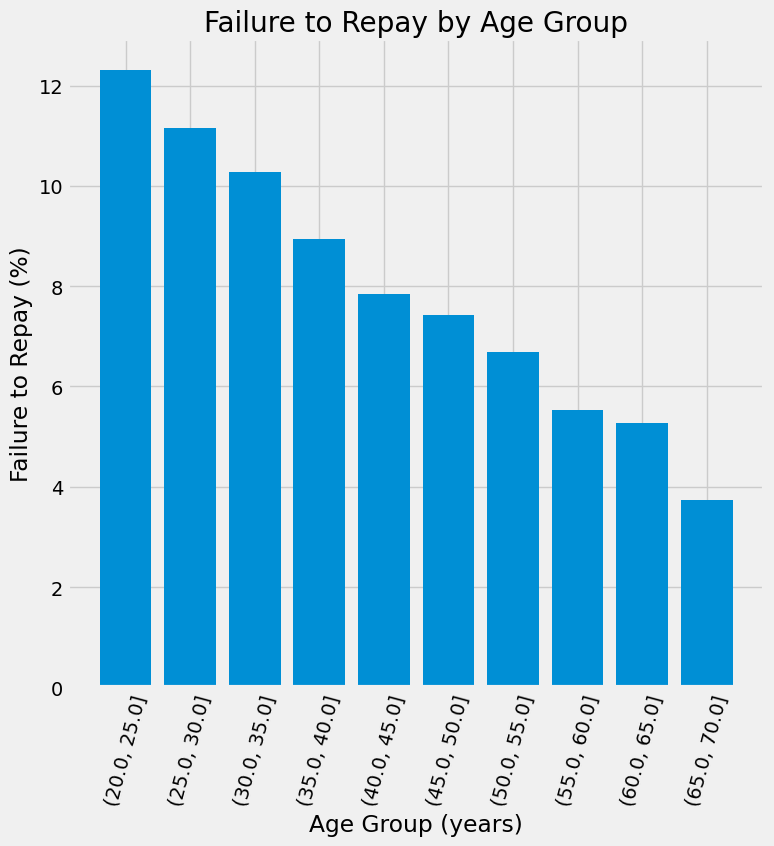

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

# clear trend: younger applicant = highier faliur to repay loan

In [28]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

poly_transformer = PolynomialFeatures(degree = 3)

poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [29]:
# train the polynomial features
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                         'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

In [30]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# align the dfs
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

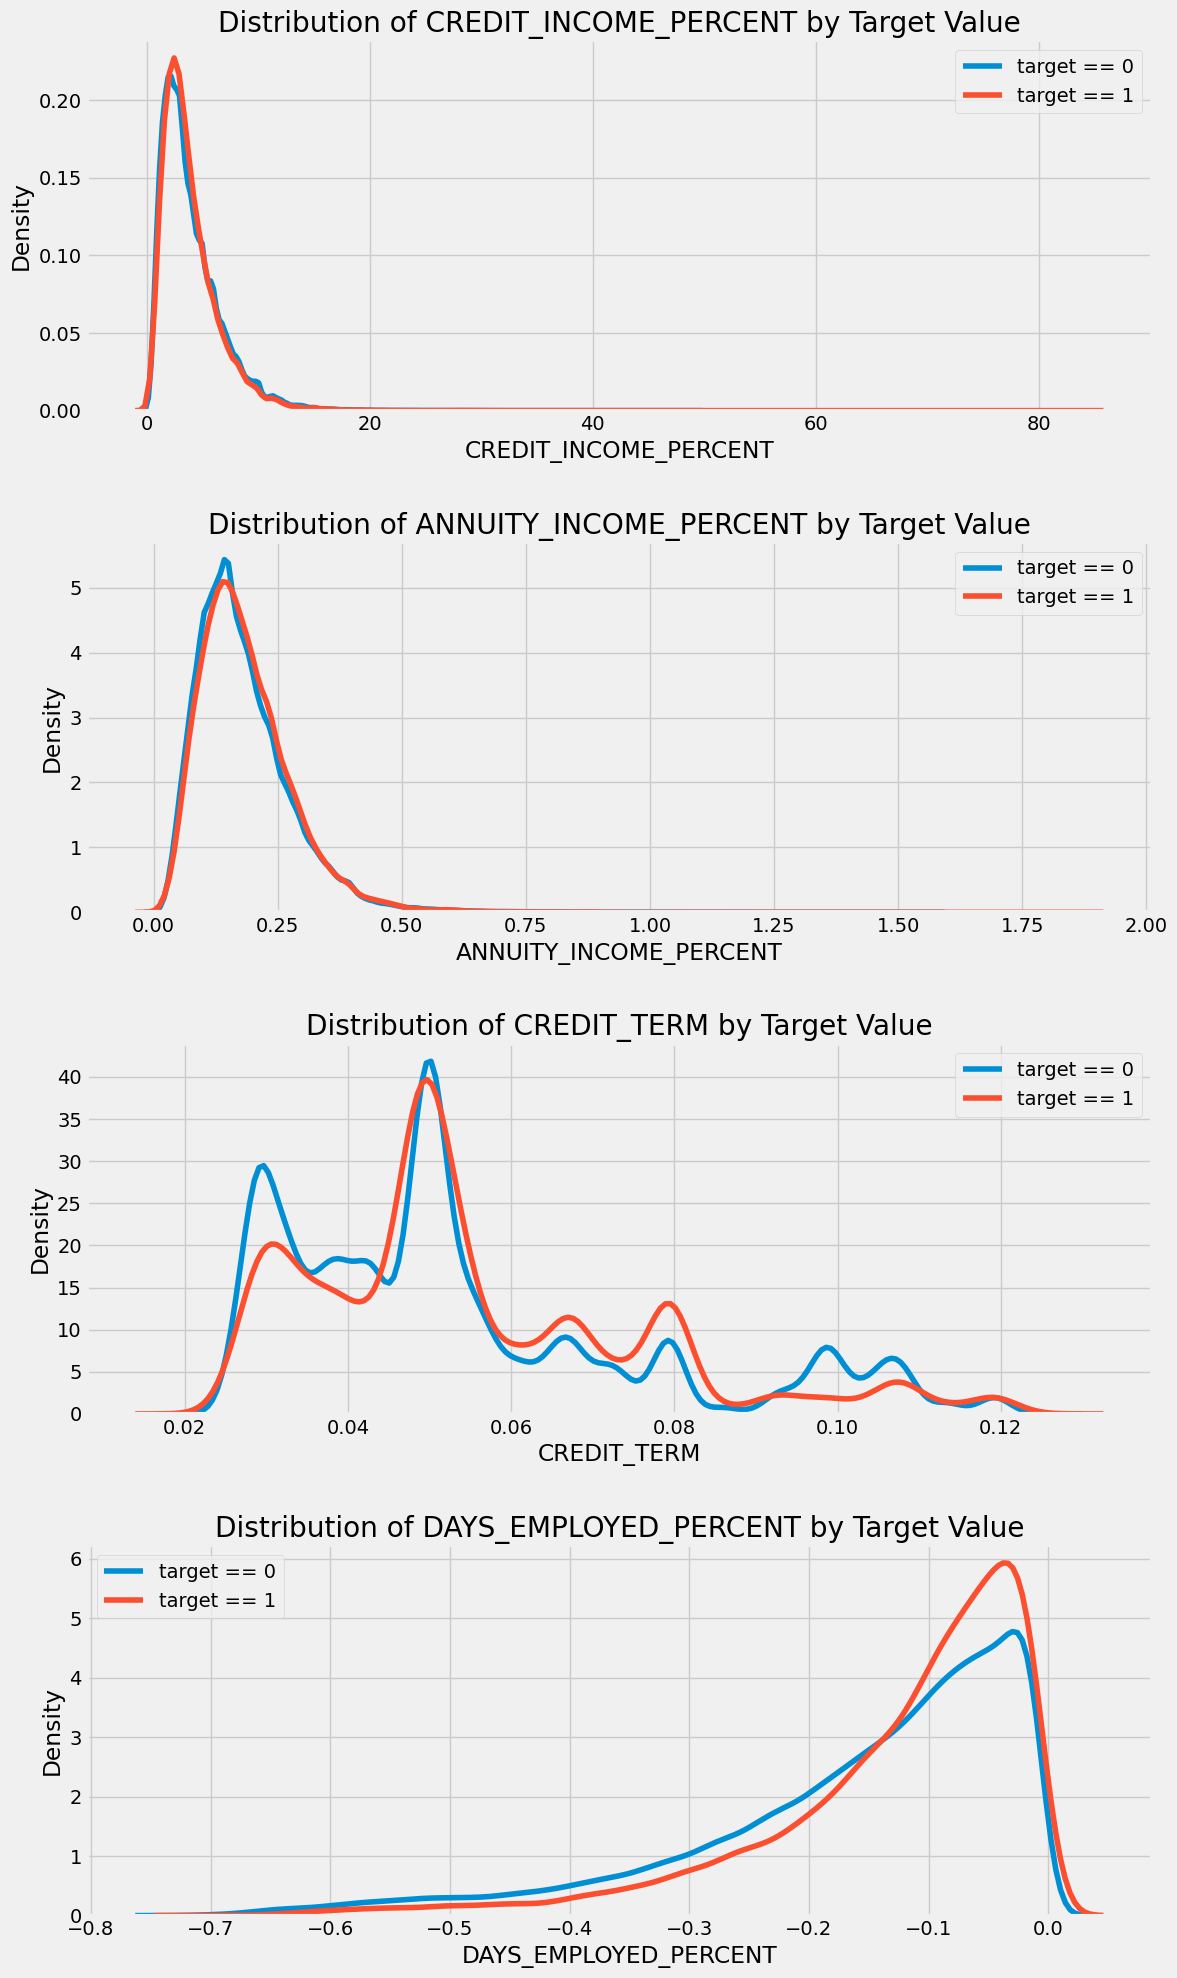

In [31]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.legend()
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

In [32]:
def get_apps_processed(apps):
    """
    feature engineering for apps
    """

    # 1.EXT_SOURCE
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

In [33]:
def get_prev_processed(prev):
    """
    feature engineering
    for previous application credit history
    """
    prev['PREV_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_CREDIT_APPL_RATIO'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']

    prev['DAYS_FIRST_DRAWING'] = prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan)
    prev['DAYS_FIRST_DUE'] = prev['DAYS_FIRST_DUE'].replace(365243, np.nan)
    prev['DAYS_LAST_DUE_1ST_VERSION'] = prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan)
    prev['DAYS_LAST_DUE'] = prev['DAYS_LAST_DUE'].replace(365243, np.nan)
    prev['DAYS_TERMINATION'] = prev['DAYS_TERMINATION'].replace(365243, np.nan)

    prev['PREV_DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    all_pay = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['PREV_INTERESTS_RATE'] = (all_pay/prev['AMT_CREDIT'] - 1)/prev['CNT_PAYMENT']

    return prev

def get_prev_amt_agg(prev):
    """
    feature enginnering for the previous credit application
    """
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
        
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_group = prev.groupby('SK_ID_CURR')
    prev_amt_agg = prev_group.agg(agg_dict)
    prev_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

    return prev_amt_agg

def get_prev_refused_appr_agg(prev):
    """
    PREV_APPROVED_COUNT : Credit application approved count
    PREV_REFUSED_COUNT :  Credit application refused count
    """
    prev_refused_appr_group = prev[prev['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
    prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()
    prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
    prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)
    return prev_refused_appr_agg


def get_prev_days365_agg(prev):
    """
    DAYS_DESCISION means How many days have been take since the previous credit application made.
    Somehow this feature is important.
    """
    cond_days365 = prev['DAYS_DECISION'] > -365
    prev_days365_group = prev[cond_days365].groupby('SK_ID_CURR')
    agg_dict = {
      'SK_ID_CURR':['count'],
      'AMT_CREDIT':['mean', 'max', 'sum'],
      'AMT_ANNUITY':['mean', 'max', 'sum'], 
      'AMT_APPLICATION':['mean', 'max', 'sum'],
      'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
      'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
      'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
      'DAYS_DECISION': ['min', 'max', 'mean'],
      'CNT_PAYMENT': ['mean', 'sum'],
      
      'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
      'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
      'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
      'PREV_GOODS_APPL_RATIO':['mean', 'max'],
      'PREV_DAYS_LAST_DUE_DIFF':['mean', 'max', 'sum'],
      'PREV_INTERESTS_RATE':['mean', 'max']
    }

    prev_days365_agg = prev_days365_group.agg(agg_dict)

    # multi index 
    prev_days365_agg.columns = ["PREV_D365_"+ "_".join(x).upper() for x in prev_days365_agg.columns.ravel()]

    return prev_days365_agg

def get_prev_agg(prev):
    prev = get_prev_processed(prev)
    prev_amt_agg = get_prev_amt_agg(prev)
    prev_refused_appr_agg = get_prev_refused_appr_agg(prev)
    prev_days365_agg = get_prev_days365_agg(prev)
    
    # prev_amt_agg
    prev_agg = prev_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
    prev_agg = prev_agg.merge(prev_days365_agg, on='SK_ID_CURR', how='left')
    # SK_ID_CURR APPROVED_COUNT REFUSED_COUNT
    prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    prev_agg['PREV_APPROVED_RATIO'] = prev_agg['PREV_APPROVED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
    # 'PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT' drop 
    prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)
    
    return prev_agg

In [34]:
def get_bureau_processed(bureau):
    bureau['BUREAU_ENDDATE_FACT_DIFF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    bureau['BUREAU_CREDIT_DEBT_DIFF'] = bureau['AMT_CREDIT_SUM_DEBT'] - bureau['AMT_CREDIT_SUM']
    
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)
    
    return bureau

def get_bureau_day_amt_agg(bureau):
    bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],

    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_grp = bureau.groupby('SK_ID_CURR')
    bureau_day_amt_agg = bureau_grp.agg(bureau_agg_dict)
    bureau_day_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_day_amt_agg.columns.ravel()]
    # SK_ID_CURR reset_index()
    bureau_day_amt_agg = bureau_day_amt_agg.reset_index()
    #print('bureau_day_amt_agg shape:', bureau_day_amt_agg.shape)
    return bureau_day_amt_agg

def get_bureau_active_agg(bureau):
    cond_active = bureau['CREDIT_ACTIVE'] == 'Active'
    bureau_active_grp = bureau[cond_active].groupby(['SK_ID_CURR'])
    bureau_agg_dict = {
      'SK_ID_BUREAU':['count'],
      'DAYS_CREDIT':['min', 'max', 'mean'],
      'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
      'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
      'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
      'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
      'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
      'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
      'AMT_ANNUITY': ['max', 'mean', 'sum'],

      'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
      'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
      'BUREAU_IS_DPD':['mean', 'sum'],
      'BUREAU_IS_DPD_OVER120':['mean', 'sum']
      }

    bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
    bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()] 
    bureau_active_agg = bureau_active_agg.reset_index()

    return bureau_active_agg


def get_bureau_bal_agg(bureau, bureau_bal):
    bureau_bal = bureau_bal.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], on='SK_ID_BUREAU', how='left')
    bureau_bal['BUREAU_BAL_IS_DPD'] = bureau_bal['STATUS'].apply(lambda x: 1 if x in['1','2','3','4','5']  else 0)
    bureau_bal['BUREAU_BAL_IS_DPD_OVER120'] = bureau_bal['STATUS'].apply(lambda x: 1 if x =='5'  else 0)
    bureau_bal_grp = bureau_bal.groupby('SK_ID_CURR')

    bureau_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'MONTHS_BALANCE':['min', 'max', 'mean'],
        'BUREAU_BAL_IS_DPD':['mean', 'sum'],
        'BUREAU_BAL_IS_DPD_OVER120':['mean', 'sum']
    }

    bureau_bal_agg = bureau_bal_grp.agg(bureau_bal_agg_dict)
    bureau_bal_agg.columns = [ 'BUREAU_BAL_'+('_').join(column).upper() for column in bureau_bal_agg.columns.ravel() ]

    bureau_bal_agg = bureau_bal_agg.reset_index()
    return bureau_bal_agg

def get_bureau_agg(bureau, bureau_bal):
    bureau = get_bureau_processed(bureau)
    bureau_day_amt_agg = get_bureau_day_amt_agg(bureau)
    bureau_active_agg = get_bureau_active_agg(bureau)
    bureau_bal_agg = get_bureau_bal_agg(bureau, bureau_bal)
    
    bureau_agg = bureau_day_amt_agg.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
    bureau_agg['BUREAU_ACT_IS_DPD_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    bureau_agg['BUREAU_ACT_IS_DPD_OVER120_RATIO'] = bureau_agg['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']/bureau_agg['BUREAU_SK_ID_BUREAU_COUNT']
    
    bureau_agg = bureau_agg.merge(bureau_bal_agg, on='SK_ID_CURR', how='left')
    #bureau_agg = bureau_agg.merge(bureau_days750_agg, on='SK_ID_CURR', how='left') 
    
    return bureau_agg

In [35]:
def get_pos_bal_agg(pos_bal):
    cond_over_0 = pos_bal['SK_DPD'] > 0
    cond_100 = (pos_bal['SK_DPD'] < 100) & (pos_bal['SK_DPD'] > 0)
    cond_over_100 = (pos_bal['SK_DPD'] >= 100)

    pos_bal['POS_IS_DPD'] = pos_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos_bal['POS_IS_DPD_UNDER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    pos_bal['POS_IS_DPD_OVER_120'] = pos_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    pos_bal_grp = pos_bal.groupby('SK_ID_CURR')
    pos_bal_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
        
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_agg = pos_bal_grp.agg(pos_bal_agg_dict)

    pos_bal_agg.columns = [('POS_')+('_').join(column).upper() for column in pos_bal_agg.columns.ravel()]
    
    cond_months = pos_bal['MONTHS_BALANCE'] > -20
    pos_bal_m20_grp = pos_bal[cond_months].groupby('SK_ID_CURR')
    pos_bal_m20_agg_dict = {
        'SK_ID_CURR':['count'], 
        'MONTHS_BALANCE':['min', 'mean', 'max'], 
        'SK_DPD':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT':['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE':['min', 'max', 'mean', 'sum'],
 
        'POS_IS_DPD':['mean', 'sum'],
        'POS_IS_DPD_UNDER_120':['mean', 'sum'],
        'POS_IS_DPD_OVER_120':['mean', 'sum']
    }

    pos_bal_m20_agg = pos_bal_m20_grp.agg(pos_bal_m20_agg_dict)

    pos_bal_m20_agg.columns = [('POS_M20')+('_').join(column).upper() for column in pos_bal_m20_agg.columns.ravel()]
    pos_bal_agg = pos_bal_agg.merge(pos_bal_m20_agg, on='SK_ID_CURR', how='left')
    pos_bal_agg = pos_bal_agg.reset_index()
    
    
    return pos_bal_agg

In [36]:
def get_install_agg(install):
    install['AMT_DIFF'] = install['AMT_INSTALMENT'] - install['AMT_PAYMENT']
    install['AMT_RATIO'] =  (install['AMT_PAYMENT'] +1)/ (install['AMT_INSTALMENT'] + 1)
    install['SK_DPD'] = install['DAYS_ENTRY_PAYMENT'] - install['DAYS_INSTALMENT']

    install['INS_IS_DPD'] = install['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    install['INS_IS_DPD_UNDER_120'] = install['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    install['INS_IS_DPD_OVER_120'] = install['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    install_grp = install.groupby('SK_ID_CURR')

    install_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }

    install_agg = install_grp.agg(install_agg_dict)
    install_agg.columns = ['INS_'+('_').join(column).upper() for column in install_agg.columns.ravel()]

    cond_day = install['DAYS_ENTRY_PAYMENT'] >= -365
    install_d365_grp = install[cond_day].groupby('SK_ID_CURR')
    install_d365_agg_dict = {
        'SK_ID_CURR':['count'],
        'NUM_INSTALMENT_VERSION':['nunique'], 
        'DAYS_ENTRY_PAYMENT':['mean', 'max', 'sum'],
        'DAYS_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_INSTALMENT':['mean', 'max', 'sum'],
        'AMT_PAYMENT':['mean', 'max','sum'],

        'AMT_DIFF':['mean','min', 'max','sum'],
        'AMT_RATIO':['mean', 'max'],
        'SK_DPD':['mean', 'min', 'max'],
        'INS_IS_DPD':['mean', 'sum'],
        'INS_IS_DPD_UNDER_120':['mean', 'sum'],
        'INS_IS_DPD_OVER_120':['mean', 'sum']    
    }
    
    install_d365_agg = install_d365_grp.agg(install_d365_agg_dict)
    install_d365_agg.columns = ['INS_D365'+('_').join(column).upper() for column in install_d365_agg.columns.ravel()]
    
    install_agg = install_agg.merge(install_d365_agg, on='SK_ID_CURR', how='left')
    install_agg = install_agg.reset_index()
    
    return install_agg

In [37]:
def get_card_bal_agg(card_bal):
    card_bal['BALANCE_LIMIT_RATIO'] = card_bal['AMT_BALANCE']/card_bal['AMT_CREDIT_LIMIT_ACTUAL']
    card_bal['DRAWING_LIMIT_RATIO'] = card_bal['AMT_DRAWINGS_CURRENT'] / card_bal['AMT_CREDIT_LIMIT_ACTUAL']

    card_bal['CARD_IS_DPD'] = card_bal['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    card_bal['CARD_IS_DPD_UNDER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if (x > 0) & (x <120) else 0 )
    card_bal['CARD_IS_DPD_OVER_120'] = card_bal['SK_DPD'].apply(lambda x:1 if x >= 120 else 0)

    card_bal_grp = card_bal.groupby('SK_ID_CURR')
    card_bal_agg_dict = {
        'SK_ID_CURR':['count'],
        'AMT_BALANCE':['max'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],

        'BALANCE_LIMIT_RATIO':['min','max'],
        'DRAWING_LIMIT_RATIO':['min', 'max'],
        'CARD_IS_DPD':['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120':['mean', 'sum'],
        'CARD_IS_DPD_OVER_120':['mean', 'sum']    
    }
    card_bal_agg = card_bal_grp.agg(card_bal_agg_dict)
    card_bal_agg.columns = ['CARD_'+('_').join(column).upper() for column in card_bal_agg.columns.ravel()]

    card_bal_agg = card_bal_agg.reset_index()
    
    cond_month = card_bal.MONTHS_BALANCE >= -3
    card_bal_m3_grp = card_bal[cond_month].groupby('SK_ID_CURR')
    card_bal_m3_agg = card_bal_m3_grp.agg(card_bal_agg_dict)
    card_bal_m3_agg.columns = ['CARD_M3'+('_').join(column).upper() for column in card_bal_m3_agg.columns.ravel()]
    
    card_bal_agg = card_bal_agg.merge(card_bal_m3_agg, on='SK_ID_CURR', how='left')
    card_bal_agg = card_bal_agg.reset_index()
    
    return card_bal_agg